In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## Which image mode is best?
- timm (PyTorch Image Moels) provides state of the art pre trained computer vision models

In [4]:
# model benchmarks
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (546/546), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 546 (delta 219), reused 331 (delta 155), pack-reused 0
Receiving objects: 100% (546/546), 2.26 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (219/219), done.
/kaggle/working/pytorch-image-models/results


In [5]:
# Using Pandas, we read the two CSV files and merge them together
import pandas as pd
df_results = pd.read_csv("results-imagenet.csv")

In [6]:
# add a family column that will allow us to group architectures into categories of similar characteristics
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

In [7]:
df = get_data("infer", "infer_samples_per_sec")

## Inference Results
- x axis shows how many secons to process one image
- y axis shows accuracy on imagenet
- size of each bubble proportional to the size of images used in testing
- color shows what "family" the architecture is from

In [10]:
import plotly.express as px
w, h, = 1000, 800

def show_all(df, title, size):
    return px.scatter(
        df, 
        width=w, 
        height=h, 
        size=df[size]**2, 
        title=title,
        x="secs",
        y="top1",
        log_x=True,
        color="family",
        hover_name="model",
        hover_data=[size]
    )

In [11]:
show_all(df, "Inference", "infer_img_size")

In [12]:
# add lines through the points of each family, to see how they compare
subs = 'levit|resnetd?|regnetx|vgg|convnext.*|efficientnetv2|beit|swin'
def show_subs(df, title, size):
    df_subs = df[df.family.str.fullmatch(subs)]
    return px.scatter(df_subs, width=w, height=h, size=df_subs[size]**2, title=title,
        trendline="ols", trendline_options={'log_x':True},
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])
show_subs(df, "Inference", "infer_img_size")

- levit family models are extremely fast for image recognition and the most accurate amongst faster models
    - models are a hybrid of best ideas from CNNs and transformers
- Oftern parameter count is used in papers as a proxy for speed. However there is a wide variation in speeds at each level of parameter count so it's not a useful proxy


In [13]:
# see parameter counts
px.scatter(df, width=w, height=h,
    x='param_count_x',  y='secs', log_x=True, log_y=True, color='infer_img_size',
    hover_name='model', hover_data=['infer_samples_per_sec', 'family']
)

## Training results

In [14]:
# grab the data
tdf = get_data("train", "train_samples_per_sec")

# repeat the family plot as we did above
show_all(tdf, "Training", "train_img_size")

In [15]:
# look at chose subset of models
show_subs(tdf, "Training", "train_img_size")

- speed depends on hardware
- a modern GPU may yield different results
- transformer based models might have worse performance in general on CPUs

## How does a neural net really work?
### Fitting a function with gradient descent
- Neural nets are just mathematical functions
    - multiples each input by a number of values. Called parameters
    - adds them up for each group of values
    - replaces the negative numbers with zeros
 - This represents 1 layer. These three steps are repeated using the outputs of the previous layer as the inputs to the next
 - Initially the parameters are selected randomly. Therefore a newly created neural net doesn't do anything useful at all - it's random
 - to get the function to learn we change the parameters to make them better
 - To do this we use **gradient descent**
 

In [17]:
from ipywidgets import interact
from fastai.basics import *

plt.rc("figure", dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color="r", ylim=None):
    x = torch.linspace(min, max, 100)[:,None]
    if ylim: 
        plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None:
        plt.title(title)

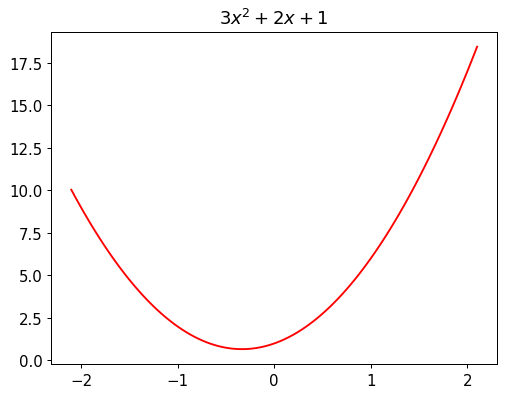

In [18]:
def f(x): return 3*x**2 + 2*x + 1
plot_function(f, "$3x^2 + 2x + 1$")

In [19]:
# this quadratic is of the form ax^2 + bx + c, with 3 parameters a = 3, b = 2, c = 1
# create a function that calaculates the value of a point on any quadratic
def quad(a, b, c, x,): return a*x**2 + b*x + c

In [20]:
# fixing values to a, b, and c will make a quadratic. To fix values we use partial function
def mk_quad(a, b, c): return partial(quad, a, b, c)

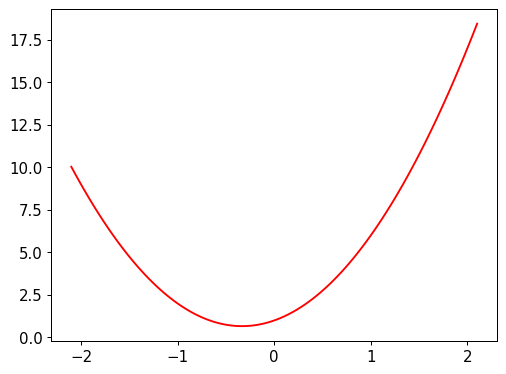

In [21]:
# recreate our previous quadratic
f2 = mk_quad(3, 2, 1)
plot_function(f2)

In [23]:
# simulate noisy measurements of our quadratic
# use gradient descent to see if we can recreate the original function from data

# add noise
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)

np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [24]:
# first few values of x and y
# in tensor form
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

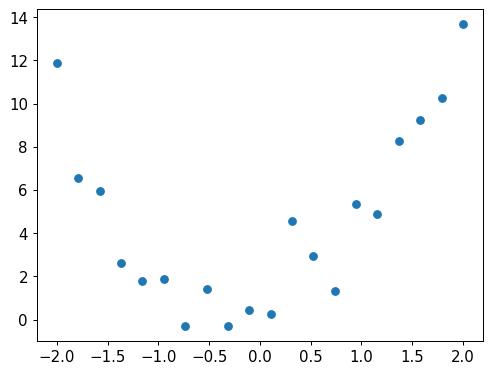

In [25]:
# draw a picture
plt.scatter(x,y)

In [26]:
# how do we find values of a, b, and c to fit data? 
# try a few values to see what fits
# create a function that overlays a quadratic on top of our data with some sliders to change a, b, and c
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3, 13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [27]:
# after changing b and c do we realize a needs adjustment
# this is tricky without have a numeric measure of our fit
# easy metric to use is the mean absolute error -- the distance from each data point to the curve

def mae(preds, acts):
    return (torch.abs(preds-acts)).mean()

In [28]:
# update our interactive function to print this at the top for us
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [29]:
# in modern neural networks we often have tens of millions of parameters to fit or more
# we can't do that by moving sliders, we need an automated process
# use calculus to figure out for each parameter if we should increase or decrease it
# use derivatives to measure the rate of change

## Automating gradient descent
- we know the gradient of our mae() function with respect to our parameters a, b, c
- we know how adjusting a will change the value of mae()
- we want to make mae() as low as possible

- find the gradient of mae() for each parameter, adjust our parameters a bit in the opposite direction to the sign of the gradient

- we need a function that takes all parameters a, b, c as a single vector input and returns the value mae() based on those parameters

In [30]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [31]:
# pick 1.1 as arbitrary starting values
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

In [33]:
# to tell PyTorch to calculate the gradient we call requires_grad_()
abc = torch.tensor([1.1, 1.1, 1.1])
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [34]:
# we can now calculate mae(), when doing gradient descent we try to minimize loss
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [35]:
# to get PyTorch to calculate gradients, we call backward()
loss.backward()

# gradients stored in an attribute called grad
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

In [36]:
# according to these gradients our params are a bit low
# lets increase them a bit
# subtract the gradient, multiplied by a small number

# we use no_grad to disable calculation of gradients for any operations
# this is because abc -= abc.grad*0.01 is not part of our quadratic model, so we don't want derivitives to include that calculation
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f"loss={loss:.2f}")

loss=2.40


In [38]:
# loss has gone down
# small number we multiply is also called the learning rate
# loop a few more iterations

for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad*0.01
    print(f"step={i}; loss={loss:.2f}")

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


In [39]:
# if we keep running this loop eventually our loss will increase
# once we get close to the correct answer it's possible to overshoot it
# thus we need to decrease learning rate as we train
# done using a learning rate schedule

## How a neural network approximates any given function
- nerual networks are very expressive (infinitely expressive)
- they can approximate any computable function given enough parameters
- the way neural network approximates a function is very simple
    - matrix multiplication, multiplying things together and adding them up
    - function max(x, 0), replaces all negative numbers with 0


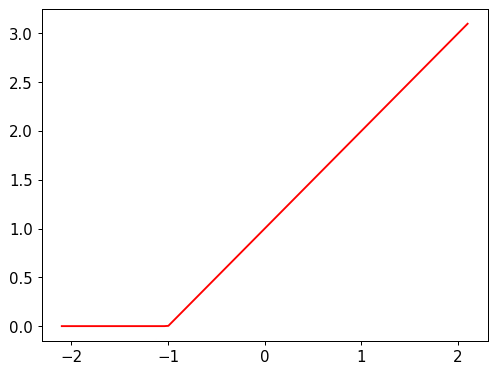

In [40]:
# max(x, 0) written as np.clip(x,0) in PyTorch
def rectified_linear(m, b, x):
    y = m*x+b
    return torch.clip(y, 0.)

plot_function(partial(rectified_linear, 1,1))

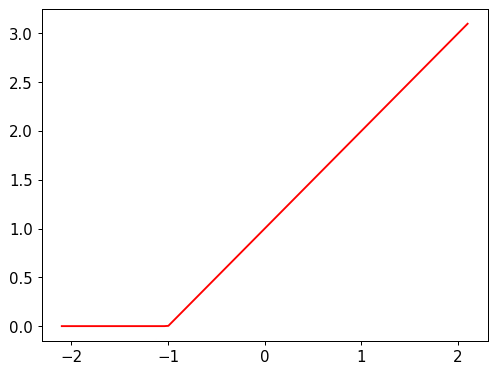

In [43]:
# we can also use F.relu(x) which is the same thing. F refers to the torch.nn.functional module
import torch.nn.functional as F
def rectified_linear2(m,x,b): 
    return F.relu(m*x+b)

plot_function(partial(rectified_linear2, 1, 1))

In [44]:
# change parameters m and b to see how this function behaves
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [45]:
# m changes the slope
# b changes where the hook appears

In [46]:
# these functions don't do much on their own but when added together
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1, 6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

In [48]:
# with two linear functions added together we can approximate any function with a single input
# Any time the function doesn't quite match you can add a few more additions to the mix to make it closer
# this exact same approach can be expanded to functions of 2, 3, or more parameters